# Tutorial: Magnetic field processing

This tutorial will teach you how to perform the processing steps which require magnetic field calculations like mapping along the field line and calculations of adiabatic invariants.

We will use the time-binned variables from the cdf file for the tutorial. We also use energies and pitch angles for this tutorial and fold the pitch angles around 90 degrees assuming a symmetric pitch-angle distribution.

In [1]:
import logging
import sys
from datetime import datetime, timedelta, timezone

from astropy import units as u

import el_paso as ep

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

extraction_infos = [
    ep.ExtractionInfo(
        result_key="Epoch",
        name_or_column="Epoch_Ele",
        unit=ep.units.cdf_epoch,
    ),
    ep.ExtractionInfo(
        result_key="Energy",
        name_or_column="HOPE_ENERGY_Ele",
        unit=u.eV,
    ),
    ep.ExtractionInfo(
        result_key="Pitch_angle",
        name_or_column="PITCH_ANGLE",
        unit=u.deg,
        is_time_dependent=False,
    ),
    ep.ExtractionInfo(
        result_key="FEDU",
        name_or_column="FEDU",
        unit=(u.cm**2 * u.s * u.sr * u.keV) ** (-1),
    ),
    ep.ExtractionInfo(
        result_key="xGEO",
        name_or_column="Position_Ele",
        unit=u.km,
    ),
]

start_time = datetime(2017, 7, 30, tzinfo=timezone.utc)
end_time = datetime(2017, 8, 1, 23, 59, 59, tzinfo=timezone.utc)

file_name_stem = "rbspa_rel04_ect-hope-pa-l3_YYYYMMDD_.{6}.cdf"

ep.download(
    start_time,
    end_time,
    save_path=".",
    download_url="https://spdf.gsfc.nasa.gov/pub/data/rbsp/rbspa/l3/ect/hope/pitchangle/rel04/YYYY/",
    file_name_stem=file_name_stem,
    file_cadence="daily",
    method="request",
    skip_existing=True,
)

variables = ep.extract_variables_from_files(
    start_time, end_time, "daily", data_path=".", file_name_stem=file_name_stem, extraction_infos=extraction_infos
)

time_bin_methods = {
    "xGEO": ep.TimeBinMethod.NanMean,
    "Energy": ep.TimeBinMethod.NanMedian,
    "FEDU": ep.TimeBinMethod.NanMedian,
    "Pitch_angle": ep.TimeBinMethod.Repeat,
}

binned_time_variable = ep.processing.bin_by_time(
    variables["Epoch"],
    variables=variables,
    time_bin_method_dict=time_bin_methods,
    time_binning_cadence=timedelta(minutes=5),
)

variables["FEDU"].transpose_data([0, 2, 1])  # making it having dimensions (time, energy, pitch angle)
ep.processing.fold_pitch_angles_and_flux(variables["FEDU"], variables["Pitch_angle"])

# not needed anymore
del variables["Epoch"]

Logger not instantiated.
Basic logger can be instantiated using `logging.basicConfig(level=logging.INFO)`
INFO:el_paso.download:File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170730_v7.3.0.cdf
INFO:el_paso.download:File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170731_v7.4.0.cdf
INFO:el_paso.download:File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170801_v7.3.0.cdf
INFO:el_paso.utils:		Finished in 0.369 seconds
INFO:el_paso.extract_variables_from_files:Extracting variables ...
INFO:el_paso.processing.bin_by_time:Binning by time...
  .to_pydatetime()

INFO:el_paso.utils:		Finished in 0.946 seconds
INFO:el_paso.processing.fold_pitch_angles_and_flux:Folding pitch angles and flux ...
INFO:el_paso.utils:		Finished in 0.033 seconds


Now we are ready to perform the magnetic field calculations. To make this most efficient, there exists a single function, which calculates all derived variables at once.
The use specifies which variables should be calculated, which magnetic field model should be used, and which options for IRBEM are chosen (IRBEM is the underlying library performing the magnetic field calculations).

We will start by calculating just the variables which dependent on the satellite's position but not on the particles. The full list of available variable names can be found HERE. 

INFO:root:OMNI Low Res  data directory: /home/jhawar/.elpaso/OMNI_low_res
INFO:root:Kp Niemegk  data directory: /home/jhawar/.elpaso/KpNiemegk
INFO:root:Reading omni from 2017-07-30 00:00:11+00:00 to 2017-08-01 23:55:11+00:00
INFO:root:Setting NaNs in omni from 2017-08-02 02:55:11+00:00 to 2017-08-01 23:55:11+00:00
INFO:root:Percentage of NaNs in data frame: 0.00%
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating local magnetic field values ...
INFO:el_paso.utils:		Finished in 0.007 seconds
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating magnetic local time ...
INFO:el_paso.utils:		Finished in 0.013 seconds
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating magnetic field and radial distance at the equator ...


  0%|          | 0/864 [00:01<?, ?it/s]

INFO:el_paso.utils:		Finished in 1.130 seconds


Text(0, 0.5, 'R_eq (RE)')

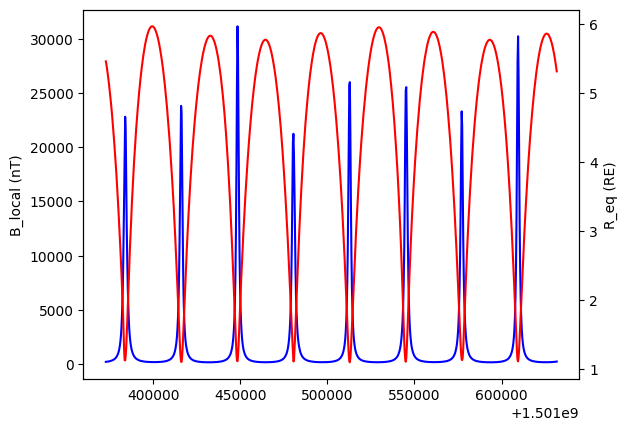

In [2]:
# Calculate magnetic field variables
from matplotlib import pyplot as plt

num_cores = 4
irbem_options = [1, 1, 4, 4, 0]
irbem_lib_path = "../IRBEM/libirbem.so"

variables_to_compute: ep.processing.VariableRequest = [
    ("B_local", "T89"),
    ("MLT", "T89"),
    ("B_eq", "T89"),
    ("R_eq", "T89"),
]

magnetic_field_variables = ep.processing.compute_magnetic_field_variables(
    time_var=binned_time_variable,
    xgeo_var=variables["xGEO"],
    variables_to_compute=variables_to_compute,
    irbem_lib_path=irbem_lib_path,
    irbem_options=irbem_options,
    num_cores=num_cores,
)

plt.plot(binned_time_variable.get_data(), magnetic_field_variables["B_local_T89"].get_data(), "b", label="B_local")
plt.ylabel("B_local (nT)")

yyaxis = plt.gca().twinx()
yyaxis.plot(binned_time_variable.get_data(), magnetic_field_variables["R_eq_T89"].get_data(), "r", label="R_eq")
plt.xlabel("Time")
plt.ylabel("R_eq (RE)")

Next, we want to calculate equatorial pitch angles and adiabatic invariants. In this case, we have to provide the pitch-angles and energy variables as well.

The calculation of Lstar is quite heavy, so we will only calculate a small time frame for this tutorial.

INFO:root:OMNI Low Res  data directory: /home/jhawar/.elpaso/OMNI_low_res
INFO:root:Kp Niemegk  data directory: /home/jhawar/.elpaso/KpNiemegk
INFO:root:Reading omni from 2017-07-30 00:00:11+00:00 to 2017-07-30 00:10:11+00:00
INFO:root:Setting NaNs in omni from 2017-07-30 03:10:11+00:00 to 2017-07-30 00:10:11+00:00
INFO:root:Percentage of NaNs in data frame: 0.00%
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating local magnetic field values ...
INFO:el_paso.utils:		Finished in 0.001 seconds
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating magnetic local time ...
INFO:el_paso.utils:		Finished in 0.001 seconds
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating magnetic field and radial distance at the equator ...


  0%|          | 0/3 [00:01<?, ?it/s]

INFO:el_paso.utils:		Finished in 1.021 seconds
INFO:el_paso.processing.compute_magnetic_field_variables:	Calculating equatorial pitch angle ...
INFO:el_paso.utils:		Equatorial pitch angle calculation finished in 0.001 seconds
INFO:el_paso.processing.compute_magnetic_field_variables:	Calculating invariant mu ...
INFO:el_paso.utils:		Invariant mu calculation finished in 0.000 seconds
INFO:el_paso.processing.compute_magnetic_field_variables:	Calculating invariant K ...
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating Lstar and J ...



 67%|██████▋   | 2/3 [00:07<00:03,  3.50s/it]

INFO:el_paso.utils:		Finished in 7.029 seconds
INFO:el_paso.processing.magnetic_field_utils.magnetic_field_functions:	Calculating mirror points ...



  0%|          | 0/3 [00:01<?, ?it/s]

INFO:el_paso.utils:		Finished in 1.028 seconds
INFO:el_paso.utils:		Invariant K calculation finished in 8.059 seconds


(2.0, 6.0)

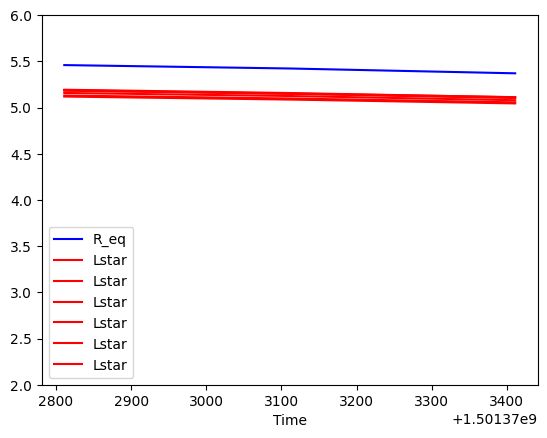

In [3]:
for var in variables.values():
    var.truncate(binned_time_variable, start_time=start_time, end_time=start_time + timedelta(hours=0.2))
binned_time_variable.truncate(binned_time_variable, start_time=start_time, end_time=start_time + timedelta(hours=0.2))

variables_to_compute: ep.processing.VariableRequest = [
    ("B_local", "T89"),
    ("MLT", "T89"),
    ("B_eq", "T89"),
    ("R_eq", "T89"),
    ("PA_eq", "T89"),
    ("invMu", "T89"),
    ("invK", "T89"),
    ("Lstar", "T89"),
]

magnetic_field_variables = ep.processing.compute_magnetic_field_variables(
    time_var=binned_time_variable,
    xgeo_var=variables["xGEO"],
    energy_var=variables["Energy"],
    pa_local_var=variables["Pitch_angle"],
    particle_species="electron",
    variables_to_compute=variables_to_compute,
    irbem_lib_path=irbem_lib_path,
    irbem_options=irbem_options,
    num_cores=1,
)

plt.plot(binned_time_variable.get_data(), magnetic_field_variables["R_eq_T89"].get_data(), "b", label="R_eq")
plt.plot(binned_time_variable.get_data(), magnetic_field_variables["Lstar_T89"].get_data(), "r", label="Lstar")

plt.xlabel("Time")
plt.legend()
plt.ylim((2, 6))